# Imports

In [2]:
pwd

'/home/olga/code/2020-test-sencha--olgabot/human-qfo-v2/notebooks'

In [101]:
from collections import defaultdict
from io import StringIO
import itertools
import math
import pandas as pd
import json
import os
import glob

from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import screed
import sklearn

from sklearn.metrics import f1_score, accuracy_score, jaccard_score, precision_score, recall_score, roc_auc_score, roc_curve

%matplotlib inline


import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
FIGURE_FOLDER = '/home/olga/googledrive/kmer-homology-paper/figures'

In [4]:
sns.set_context('paper')

In [5]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

## Constants

### Distance from human MYA


In [6]:
def clean_common_names_of_species(species_name):
    if species_name == 'mouse':
        return 'house mouse'
    elif species_name == 'shrew':
        return 'common shrew'
    else:
        return species_name

In [7]:
# http://timetree.org/
# "Estimated time" from human + species

distance_from_human_mya = pd.Series({
    # mus_musculus
    'house mouse': 90,
    
    # oryctolagus_cuniculus
    'rabbit': 90,
    
    # rhinolophus_sinicus
    'bat': 96,
    
    # erinaceus_europaeus
    'hedgehog': 96,
    
    # sorex_araneus, common shrew
    'common shrew': 96,
    
    # ornithorhynchus_anatinus
    'platypus': 177,
    
    # aotus_nancymaae
    'night monkey': 43.2,
    
    # ceratotherium_simum_simum
    'rhino': 96,
    
    # camelus_bactrianus
    'camel': 96,
    
    # lipotes_vexillifer
    'baiji': 96,
    
    # chinchilla_lanigera
    'chinchilla': 90,
    
    # macaca_mulatta
    'macaque': 29.44,
    
    # homo_sapiens
    'human': 0,
    
    # tupaia_chinensis
    'tupaia': 82,
    
    # peromyscus_maniculatus_bairdii
    'deer mouse': 90,
    
    # capra_hircus
    'goat': 96,
    
    # nannospalax_galili
    'spalax': 90,
    
    # phascolarctos_cinereus
    'koala': 159
})
distance_from_human_mya = distance_from_human_mya.sort_values()
distance_from_human_mya

human             0.00
macaque          29.44
night monkey     43.20
tupaia           82.00
house mouse      90.00
rabbit           90.00
deer mouse       90.00
spalax           90.00
chinchilla       90.00
goat             96.00
camel            96.00
rhino            96.00
common shrew     96.00
hedgehog         96.00
bat              96.00
baiji            96.00
koala           159.00
platypus        177.00
dtype: float64

In [ ]:
!hostname

## Read busco mammalia 

In [8]:
s = '''common_name	scientific_name
human	Homo sapiens
house mouse	Mus musculus
spalax	Nannospalax galili
baiji	Lipotes vexillifer
deer mouse	Peromyscus Maniculatus bairdii
tupaia	Tupaia chinensis
bat	Rhinolophus sinicus
rabbit	Oryctolagus cuniculus
hedgehog	Erinaceus europaeus
common shrew	Sorex araneus
platypus	Ornithorhynchus anatinus
night monkey	Aotus nancymaae
rhino	Ceratotherium simum simum
chinchilla	Chinchilla lanigera
koala	Phascolarctos cinereus
macaque	Macaca mulatta
camel	Camelus bactrianus
goat	Capra hircus'''

busco_mammalia_species = pd.read_csv(StringIO(s), sep='\t')
busco_mammalia_species['scientific_lower'] = busco_mammalia_species.scientific_name.str.lower().str.replace(' ', '_')
busco_mammalia_species = busco_mammalia_species.set_index('common_name')
busco_mammalia_species['mya'] = distance_from_human_mya
busco_mammalia_species = busco_mammalia_species.reset_index()
busco_mammalia_species = busco_mammalia_species.set_index('scientific_lower')
describe(busco_mammalia_species)

(18, 3)
--- First 5 entries ---


,common_name,scientific_name,mya
scientific_lower,,,
homo_sapiens,human,Homo sapiens,0.0
mus_musculus,house mouse,Mus musculus,90.0
nannospalax_galili,spalax,Nannospalax galili,90.0
lipotes_vexillifer,baiji,Lipotes vexillifer,96.0
peromyscus_maniculatus_bairdii,deer mouse,Peromyscus Maniculatus bairdii,90.0


### Remove rogue TQDM instances

In [9]:
def remove_rogue_tqdm():
    import tqdm
    try:
        tqdm._instances.clear()
    except AttributeError:
        pass

# Analyze protien-coding classification metrics

## Get number of protein sequences per species

In [10]:
proteome_folder = '/home/olga/data_lg/czbiohub-reference/uniprot/releases/2019_11/manually_downloaded/mammalia_busco_subsets'

col = 'proteome_size'
busco_mammalia_species[col] = 0
for fasta in glob.glob(os.path.join(proteome_folder, '*.fasta')):
    species_lower = os.path.basename(fasta).split('__')[-1].split('.')[0]
    proteome_size = sum(1 for _ in screed.open(fasta))
    
    busco_mammalia_species.loc[species_lower, col] = proteome_size 
busco_mammalia_species = busco_mammalia_species.sort_values('mya')
describe(busco_mammalia_species)


(18, 4)
--- First 5 entries ---


,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.00,15066
macaca_mulatta,macaque,Macaca mulatta,29.44,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.20,7261
tupaia_chinensis,tupaia,Tupaia chinensis,82.00,1338
mus_musculus,house mouse,Mus musculus,90.00,14519


### Plot proteome sizes

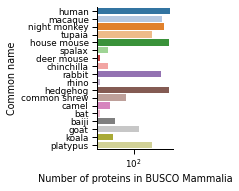

In [11]:
# fig, ax = plt.subplots(figsize=(2.75, 2.5))
g = sns.catplot(
    data=busco_mammalia_species,
    y='common_name',
    x='proteome_size',
    palette='tab20',
    kind='bar',
    height=2.5
#     order=
)
# sns.despine()
g.set(xscale='log', xlabel='Number of proteins in BUSCO Mammalia', ylabel='Common name')

pdf = os.path.join(FIGURE_FOLDER, 'leaftea_translate__proteome_size_barplots.pdf')
g.savefig(pdf)

### Plot proteome sizes vs mya

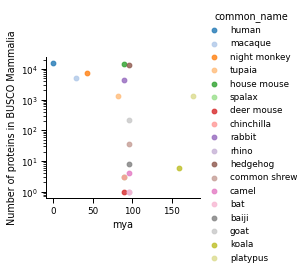

In [103]:
# fig, ax = plt.subplots()
g = sns.lmplot(
    data=busco_mammalia_species,
    x='mya',
    y='proteome_size',
    hue='common_name',
    palette='tab20',
    fit_reg=False,
    height=2.5,
    aspect=1.25
#     yscale='log'
#     order=
)
g.set(yscale='log', ylabel='Number of proteins in BUSCO Mammalia')
pdf = os.path.join(FIGURE_FOLDER, 'orphuem_translate__mya_vs_proteome_size.pdf')
g.savefig(pdf)

In [16]:
busco_mammalia_species.query('proteome_size > 1000').mya.value_counts()

90.00     2
43.20     1
29.44     1
177.00    1
96.00     1
82.00     1
0.00      1
Name: mya, dtype: int64

In [17]:
busco_mammalia_common = busco_mammalia_species.reset_index().set_index('common_name')
describe(busco_mammalia_common)

(18, 4)
--- First 5 entries ---


,scientific_lower,scientific_name,mya,proteome_size
common_name,,,,
human,homo_sapiens,Homo sapiens,0.00,15066
macaque,macaca_mulatta,Macaca mulatta,29.44,5008
night monkey,aotus_nancymaae,Aotus nancymaae,43.20,7261
tupaia,tupaia_chinensis,Tupaia chinensis,82.00,1338
house mouse,mus_musculus,Mus musculus,90.00,14519


In [18]:
print(busco_mammalia_species.to_csv(sep='\t'))

scientific_lower	common_name	scientific_name	mya	proteome_size
homo_sapiens	human	Homo sapiens	0.0	15066
macaca_mulatta	macaque	Macaca mulatta	29.44	5008
aotus_nancymaae	night monkey	Aotus nancymaae	43.2	7261
tupaia_chinensis	tupaia	Tupaia chinensis	82.0	1338
mus_musculus	house mouse	Mus musculus	90.0	14519
nannospalax_galili	spalax	Nannospalax galili	90.0	3
peromyscus_maniculatus_bairdii	deer mouse	Peromyscus Maniculatus bairdii	90.0	1
chinchilla_lanigera	chinchilla	Chinchilla lanigera	90.0	3
oryctolagus_cuniculus	rabbit	Oryctolagus cuniculus	90.0	4424
ceratotherium_simum_simum	rhino	Ceratotherium simum simum	96.0	1
erinaceus_europaeus	hedgehog	Erinaceus europaeus	96.0	13448
sorex_araneus	common shrew	Sorex araneus	96.0	36
camelus_bactrianus	camel	Camelus bactrianus	96.0	4
rhinolophus_sinicus	bat	Rhinolophus sinicus	96.0	1
lipotes_vexillifer	baiji	Lipotes vexillifer	96.0	8
capra_hircus	goat	Capra hircus	96.0	213
phascolarctos_cinereus	koala	Phascolarctos cinereus	159.0	6
ornithorhynch

## Read scikit-learn metrics

In [20]:
alphabet_to_size = {
    'protein': 20,
    'dayhoff': 6
}

In [21]:
csv = '/home/olga/data_sm/immune-evolution/pipeline-results/human-simulated/combined-across-species/busco_mammalia_coding_scores_metrics.csv'
combined_metrics = pd.read_csv(csv)
combined_metrics.species = combined_metrics.species.replace('mouse', 'house mouse')
combined_metrics['proteome'] = combined_metrics['species']
combined_metrics = combined_metrics.join(busco_mammalia_common, on='species')
combined_metrics['alphabet_ksize'] = combined_metrics.apply(
    lambda x: f'{x.alphabet} ({alphabet_to_size[x.alphabet]}-letter), ksize = {x.ksize}',
    axis=1
)
describe(combined_metrics)

(6804, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
0,baiji,dayhoff,5,0.004769,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"dayhoff (6-letter), ksize = 5"
1,baiji,dayhoff,6,0.000085,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"dayhoff (6-letter), ksize = 6"
2,baiji,dayhoff,7,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"dayhoff (6-letter), ksize = 7"
3,baiji,dayhoff,8,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"dayhoff (6-letter), ksize = 8"
4,baiji,dayhoff,9,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"dayhoff (6-letter), ksize = 9"


## Plot metrics

In [22]:
species_color_kwargs = dict(
    hue='species',
    hue_order=distance_from_human_mya.index,
    palette='viridis'
)

## Join metrics with millions of years


In [24]:
distance_from_human_mya.name = 'mya'

In [25]:
# combined_metrics_mya = combined_metrics.join(distance_from_human_mya, on='species')
# combined_metrics_mya.head()

## MYA vs classification - only ksizes relevant to protein

In [26]:
subset_score_names = 'precision_score', 'recall_score', 'f_12_score'
combined_metrics_mya_protein_ksize_precision_recall_f12 = combined_metrics.query(
    '(ksize <= 10) and (alphabet == "protein") '
    'and (score_name in @subset_score_names)'
    ' and proteome_size > 2500'
)
describe(combined_metrics_mya_protein_ksize_precision_recall_f12)


(90, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
3267,hedgehog,protein,5,0.714444,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"protein (20-letter), ksize = 5"
3268,hedgehog,protein,6,0.999495,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"protein (20-letter), ksize = 6"
3269,hedgehog,protein,7,1.000000,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"protein (20-letter), ksize = 7"
3270,hedgehog,protein,8,1.000000,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"protein (20-letter), ksize = 8"
3271,hedgehog,protein,9,1.000000,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"protein (20-letter), ksize = 9"


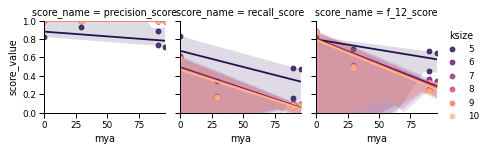

In [27]:
g = sns.lmplot(
    x='mya',
    y='score_value',
    col='score_name',
#     row='alphabet',
#     col_wrap=2,
    data=combined_metrics_mya_protein_ksize_precision_recall_f12,
    hue='ksize',
    palette='magma',
    height=2,
#     aspect=1.5,
#     margin_titles=True
)
g.set(ylim=(0, 1))

## MYA vs classification - only ksizes relevant to dayhoff

In [28]:
subset_score_names = 'precision_score', 'recall_score', 'f_12_score'
combined_metrics_mya_dayhoff_ksize_precision_recall_f12 = combined_metrics.query(
    '((ksize >= 15) or (ksize <= 20)) and (alphabet == "dayhoff") '
    'and (score_name in @subset_score_names) '
    'and (proteome_size > 1000)'
)
describe(combined_metrics_mya_dayhoff_ksize_precision_recall_f12)


(567, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
3240,hedgehog,dayhoff,5,0.478834,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"dayhoff (6-letter), ksize = 5"
3241,hedgehog,dayhoff,6,0.481325,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"dayhoff (6-letter), ksize = 6"
3242,hedgehog,dayhoff,7,0.496913,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"dayhoff (6-letter), ksize = 7"
3243,hedgehog,dayhoff,8,0.555418,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"dayhoff (6-letter), ksize = 8"
3244,hedgehog,dayhoff,9,0.663767,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0,13448.0,"dayhoff (6-letter), ksize = 9"


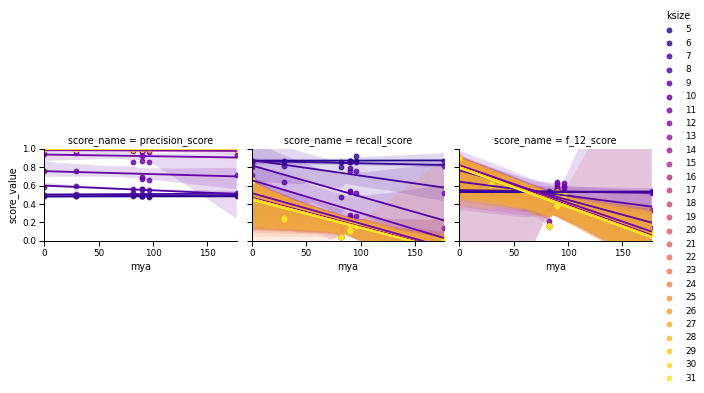

In [29]:
g = sns.lmplot(
    x='mya',
    y='score_value',
    col='score_name',
#     row='alphabet',
#     col_wrap=2,
    data=combined_metrics_mya_dayhoff_ksize_precision_recall_f12,
    hue='ksize',
    palette='plasma',
    height=2,
    aspect=1.5,
#     margin_titles=True
)
g.set(ylim=(0, 1))

### Subset to k=8

In [30]:
combined_metrics_k8 = combined_metrics.query('ksize == 8')
describe(combined_metrics_k8)

(252, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
3,baiji,dayhoff,8,0.000055,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"dayhoff (6-letter), ksize = 8"
30,baiji,protein,8,0.000018,f1_score,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,"protein (20-letter), ksize = 8"
57,bat,dayhoff,8,0.000000,f1_score,bat,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1.0,"dayhoff (6-letter), ksize = 8"
84,bat,protein,8,0.000000,f1_score,bat,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1.0,"protein (20-letter), ksize = 8"
111,camel,dayhoff,8,0.000018,f1_score,camel,camelus_bactrianus,Camelus bactrianus,96.0,4.0,"dayhoff (6-letter), ksize = 8"


## Protein k8 Plot by MYA from human

In [31]:
combined_metrics_precision_recall_f12 = combined_metrics.query(
    '(score_name in @subset_score_names) and '
    '(((alphabet == "protein") and (ksize == 8)) or '
    '((alphabet == "dayhoff") and (ksize == 17))) '
    ' and proteome_size > 4000'
)
describe(combined_metrics_precision_recall_f12)

(30, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size,alphabet_ksize
3252,hedgehog,dayhoff,17,0.999678,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.00,13448.0,"dayhoff (6-letter), ksize = 17"
3270,hedgehog,protein,8,1.000000,precision_score,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.00,13448.0,"protein (20-letter), ksize = 8"
3306,human,dayhoff,17,0.998971,precision_score,human,homo_sapiens,Homo sapiens,0.00,15066.0,"dayhoff (6-letter), ksize = 17"
3324,human,protein,8,0.999017,precision_score,human,homo_sapiens,Homo sapiens,0.00,15066.0,"protein (20-letter), ksize = 8"
3414,macaque,dayhoff,17,0.999666,precision_score,macaque,macaca_mulatta,Macaca mulatta,29.44,5008.0,"dayhoff (6-letter), ksize = 17"


## @paper - precision, recall F1 for best ksizes of dayhoff and protein

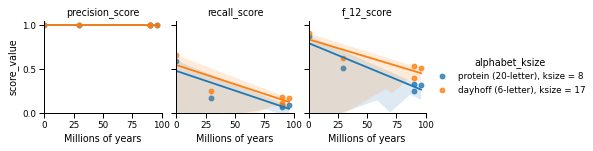

In [32]:
g = sns.lmplot(
    data=combined_metrics_precision_recall_f12,
    x='mya',
    y='score_value',
    col='score_name',
#     col_wrap=3,
    height=2,
    hue='alphabet_ksize',
#     lowess=True,
    hue_order=['protein (20-letter), ksize = 8', 'dayhoff (6-letter), ksize = 17']
)
g.set_titles('{col_name}')

g.set(xlabel='Millions of years', ylim=(0, 1.05), yticks=[0, 0.5, 1], xlim=(0, 100))
pdf = os.path.join(FIGURE_FOLDER, 'leaftea_translate__human_mouse__precision_recall_f12__protein-k8__dayhoff-k17.pdf')
g.savefig(pdf)

## Read ROC AUC csv

In [33]:
# locals()

In [34]:
csv = '/home/olga/data_sm/immune-evolution/pipeline-results/human-simulated/combined-across-species/busco_mammalia_coding_scores_roc_auc_score.csv'


combined_roc_auc_score = pd.read_csv(csv)
# combined_roc_auc_score = combined_roc_auc_score.join(distance_from_human_mya, on='species') 

combined_roc_auc_score.species = combined_roc_auc_score.species.replace(
    'mouse', 'house mouse').str.replace('_', ' ')
# Everything decreases after k > 21
combined_roc_auc_score = combined_roc_auc_score.query('ksize <= 21')
combined_roc_auc_score = combined_roc_auc_score.join(
    busco_mammalia_common, on='species')
combined_roc_auc_score.head()


,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,5,0.397805,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0
1,baiji,dayhoff,6,0.363173,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0
2,baiji,dayhoff,7,0.363950,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0
3,baiji,dayhoff,8,0.385517,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0
4,baiji,dayhoff,9,0.418185,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0


In [35]:
combined_roc_auc_score.species.value_counts()

shrew           34
rhino           34
macaque         34
chinchilla      34
human           34
hedgehog        34
rabbit          34
koala           34
camel           34
platypus        34
tupaia          34
deer mouse      34
night monkey    34
house mouse     34
spalax          34
baiji           34
goat            34
bat             34
Name: species, dtype: int64

In [36]:
max_roc_scores = combined_roc_auc_score.groupby(
    ['species', 'alphabet']).score_value.max()
max_roc_scores.name = 'max_roc_auc'
max_roc_scores = max_roc_scores.reset_index()
max_roc_scores = max_roc_scores.join(busco_mammalia_common, on='species')
describe(max_roc_scores)

(36, 7)
--- First 5 entries ---


,species,alphabet,max_roc_auc,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,0.500255,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0
1,baiji,protein,0.500607,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0
2,bat,dayhoff,0.552860,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1.0
3,bat,protein,0.503737,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1.0
4,camel,dayhoff,0.500110,camelus_bactrianus,Camelus bactrianus,96.0,4.0


In [37]:
max_roc_scores.query('max_roc_auc > 0.6')

,species,alphabet,max_roc_auc,scientific_lower,scientific_name,mya,proteome_size
12,hedgehog,dayhoff,0.869341,erinaceus_europaeus,Erinaceus europaeus,96.00,13448.0
13,hedgehog,protein,0.929230,erinaceus_europaeus,Erinaceus europaeus,96.00,13448.0
14,house mouse,dayhoff,0.880976,mus_musculus,Mus musculus,90.00,14519.0
15,house mouse,protein,0.938552,mus_musculus,Mus musculus,90.00,14519.0
16,human,dayhoff,0.996881,homo_sapiens,Homo sapiens,0.00,15066.0
17,human,protein,0.998456,homo_sapiens,Homo sapiens,0.00,15066.0
20,macaque,dayhoff,0.770334,macaca_mulatta,Macaca mulatta,29.44,5008.0
21,macaque,protein,0.789053,macaca_mulatta,Macaca mulatta,29.44,5008.0
22,night monkey,dayhoff,0.818646,aotus_nancymaae,Aotus nancymaae,43.20,7261.0
23,night monkey,protein,0.844914,aotus_nancymaae,Aotus nancymaae,43.20,7261.0


In [38]:
max_roc_scores.proteome_size.max()

15066.0

In [39]:
mya_order = sorted(distance_from_human_mya.unique())
mya_color_kwargs = dict(
        hue='mya',
    hue_order=mya_order,
    palette='cividis',
)

In [40]:
distance_from_human_mya

human             0.00
macaque          29.44
night monkey     43.20
tupaia           82.00
house mouse      90.00
rabbit           90.00
deer mouse       90.00
spalax           90.00
chinchilla       90.00
goat             96.00
camel            96.00
rhino            96.00
common shrew     96.00
hedgehog         96.00
bat              96.00
baiji            96.00
koala           159.00
platypus        177.00
Name: mya, dtype: float64

### @paper - proteome size vs max ROC AUC

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/axisgrid.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


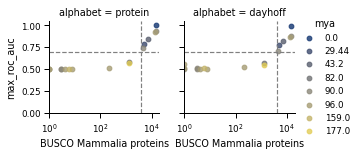

In [41]:
g = sns.lmplot(
    x='proteome_size',
    y='max_roc_auc',
    col='alphabet',
    col_order=['protein', 'dayhoff'],
    data=max_roc_scores,
    height=2,
    fit_reg=False,
    **mya_color_kwargs
)
g.set(ylim=(0, 1.05), xlim=(-10, 2e4), xlabel='BUSCO Mammalia proteins', xscale='log')
for ax in g.axes.flat:
    ax.axhline(0.7, linestyle='--', color='grey')
    ax.axvline(4000, linestyle='--', color='grey')
pdf = os.path.join(
    FIGURE_FOLDER, 
    'leaftea_translate__proteome_size_vs_max_roc_auc.pdf'
)
g.savefig(pdf)

### @paper Plot ROC AUC showing argmax for each divergence time -- both protein and dayhoff

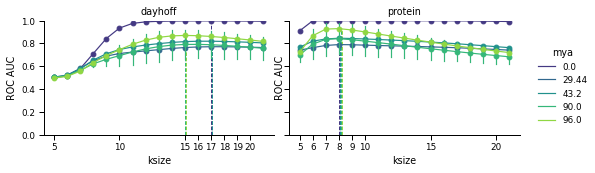

In [42]:
n_lines_plotted = defaultdict(int)
def plot_argmax(x, y, *args, **kwargs):
    idxmax = y.idxmax()
    
    global n_lines_plotted
    
    true_x = x[idxmax]
    adjusted_x = true_x + n_lines_plotted[true_x]/20
    
    plt.vlines(
        adjusted_x, 
        0, 
        y.max(),        
        linestyle='--',
        linewidth=1,
        *args, 
        **kwargs
    )
    n_lines_plotted[true_x] += 1
#     print('x:', x)
#     print('y:', y)
#     print('args:', args)
#     print('kwargs:', kwargs)
    pass

def pointplot_like(x, y, *args, **kwargs):
    """Like a pointplot, but x is true values not categorical"""
#     print('x:', x)
#     print('y:', y)
#     print('args:', args)
#     print('kwargs:', kwargs)
    
    
    new_y = y.groupby(x).mean()
    new_x = x.unique()
    plt.plot(new_x, new_y, 'o-', *args, **kwargs)
    
    y_stds = y.groupby(x).std()
    
    for x_pos, y_mean, y_sd in zip(new_x, new_y, y_stds):

        plt.plot([x_pos, x_pos], [y_mean - y_sd, y_mean + y_sd], *args, **kwargs)
    
    pass



data  = combined_roc_auc_score.query('proteome_size > 2500')


g = sns.FacetGrid(
    data=data, 
    height=2.5, aspect=1.5,
    col='alphabet',
    sharex=False,
    hue='mya',
    palette='viridis',
    hue_order=sorted(data['mya'].unique())
)
# g.map(sns.scatterplot, 'ksize', 'score_value')
g.map(pointplot_like, 'ksize', 'score_value')
g.add_legend()
g.map(plot_argmax, 'ksize', 'score_value')
g.set(ylabel='ROC AUC', 
      ylim=(0, 1), 
#       xticks=[5, 6, 7, 8, 9, 10, 15, 20]
     )
for ax in g.axes.flat:
    if 'protein' in ax.get_title():
        ax.set(xticks=[5, 6, 7, 8, 9, 10, 15, 20])
    else:
        ax.set(xticks=[5, 10, 15, 16, 17, 18, 19, 20])

g.set_titles('{col_name}')
pdf = os.path.join(
    FIGURE_FOLDER, 
    'leaftea_translate__human_mouse__roc_auc__protein_dayhoff.pdf')
g.savefig(pdf)

## Concatenate ROC AUC with other metrics

### Combine non-curve sscores

In [43]:
concatenated_metrics = pd.concat([combined_roc_auc_score, combined_metrics], ignore_index=True)
describe(concatenated_metrics)

(7416, 11)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size,proteome,alphabet_ksize
0,baiji,dayhoff,5,0.397805,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,NaN,NaN
1,baiji,dayhoff,6,0.363173,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,NaN,NaN
2,baiji,dayhoff,7,0.363950,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,NaN,NaN
3,baiji,dayhoff,8,0.385517,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,NaN,NaN
4,baiji,dayhoff,9,0.418185,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,NaN,NaN


In [44]:
concatenated_metrics.score_name.value_counts()

f1_score           972
precision_score    972
recall_score       972
f_12_score         972
accuracy_score     972
jaccard_score      972
f2_score           972
roc_auc            612
Name: score_name, dtype: int64

### Write combined metrics to csv!!!

In [45]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_metrics_concatenated.csv'
concatenated_metrics.to_csv(csv, index=False)


## Read ROC Curve csv

In [87]:
parquet = '/home/olga/data_sm/immune-evolution/pipeline-results/human-simulated/combined-across-species/busco_mammalia_coding_scores_roc_curves.parquet'


combined_roc_curve = pd.read_parquet(parquet)
# Things aren't better at k>21, even with dayhoff
combined_roc_curve = combined_roc_curve.query('ksize <= 21')
combined_roc_curve['proteome'] = combined_roc_curve['species'].map(clean_common_names_of_species).str.replace('_', ' ')
combined_roc_curve = combined_roc_curve.join(
    busco_mammalia_common, on='proteome'
)
combined_roc_curve.head()

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,proteome,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,5,0,0.000000,0.000000,2.000000,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8
1,baiji,dayhoff,5,1,0.000820,0.000705,1.000000,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8
2,baiji,dayhoff,5,2,0.000820,0.000717,0.977778,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8
3,baiji,dayhoff,5,3,0.000825,0.000726,0.977273,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8
4,baiji,dayhoff,5,4,0.000842,0.000742,0.976744,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0,8


In [88]:
sorted(combined_roc_curve['proteome'].unique())

['baiji',
 'bat',
 'camel',
 'chinchilla',
 'common shrew',
 'deer mouse',
 'goat',
 'hedgehog',
 'house mouse',
 'human',
 'koala',
 'macaque',
 'night monkey',
 'platypus',
 'rabbit',
 'rhino',
 'spalax',
 'tupaia']

## Plot ROC curves

### Plot combined roc curves

In [89]:
busco_mammalia_species_min_proteome_size = busco_mammalia_species.query('proteome_size >= 4000')
busco_mammalia_species_min_proteome_size

,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.00,15066
macaca_mulatta,macaque,Macaca mulatta,29.44,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.20,7261
mus_musculus,house mouse,Mus musculus,90.00,14519
oryctolagus_cuniculus,rabbit,Oryctolagus cuniculus,90.00,4424
erinaceus_europaeus,hedgehog,Erinaceus europaeus,96.00,13448


In [90]:
busco_mammalia_species_min_proteome_size.shape

(6, 4)

In [91]:
combined_roc_curve_min_proteome_sizes = combined_roc_curve.query('proteome in @busco_mammalia_species_min_proteome_size.common_name.values')
# combined_roc_curve_min_proteome_sizes['scientific_lower'] = combined_roc_curve_min_proteome_sizes
combined_roc_curve_min_proteome_sizes.shape

combined_roc_curve_min_proteome_sizes.proteome.unique()

array(['hedgehog', 'human', 'macaque', 'house mouse', 'night monkey',
       'rabbit'], dtype=object)

In [92]:
combined_roc_curve_min_proteome_sizes.scientific_name.unique()

array(['Erinaceus europaeus', 'Homo sapiens', 'Macaca mulatta',
       'Mus musculus', 'Aotus nancymaae', 'Oryctolagus cuniculus'],
      dtype=object)

In [93]:
species_order = busco_mammalia_species_min_proteome_size['scientific_name']
species_order

scientific_lower
homo_sapiens                      Homo sapiens
macaca_mulatta                  Macaca mulatta
aotus_nancymaae                Aotus nancymaae
mus_musculus                      Mus musculus
oryctolagus_cuniculus    Oryctolagus cuniculus
erinaceus_europaeus        Erinaceus europaeus
Name: scientific_name, dtype: object

### @paper plot roc curves for species with enough proteome size

dayhoff
protein


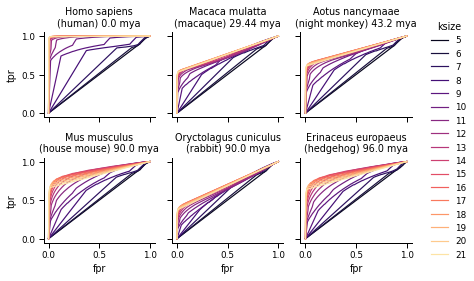

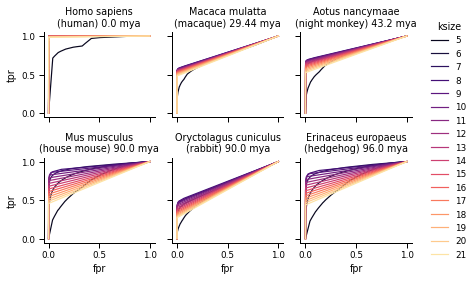

In [100]:
for alphabet, df in combined_roc_curve_min_proteome_sizes.groupby("alphabet"):
    print(alphabet)
    g = sns.FacetGrid(
        data=df,  # col='alphabet',
        hue="ksize",
        palette="magma",
        col="scientific_name",
        col_order=species_order,
        col_wrap=3,
        height=2,
    )
    g.map(plt.plot, "fpr", "tpr")
    g.add_legend()
    g.set(xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])
    g.set_titles("{col_name}")
    
    for ax in g.axes.flat:
        scientific_name = ax.get_title()
        this_species_metadata =  busco_mammalia_species_min_proteome_size.query('scientific_name == @scientific_name')
        common_name = this_species_metadata.common_name.iloc[0]
        mya = this_species_metadata.mya.iloc[0]
        new_title = f'{scientific_name}\n({common_name}) {mya} mya'
        ax.set_title(new_title)

    # Save the figure
    pdf = os.path.join(
        FIGURE_FOLDER, f"orpheum_translate__roc_curves_all_proteomes__{alphabet}.pdf"
    )
    g.tight_layout()
    g.savefig(pdf)

In [2]:
FIGURE_FOLDER

NameError: name 'FIGURE_FOLDER' is not defined

### Plot combined roc curves - protein and k=8 only


In [252]:
combined_roc_curve_protein = combined_roc_curve.query(
    '(ksize == 8) and (alphabet == "protein")'
)
print(combined_roc_curve_protein.shape)
combined_roc_curve_protein.head()

(3078, 13)


,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,scientific_lower,scientific_name,mya,proteome_size,proteome
4336,baiji,protein,8,0,0.0,0.000000,2.000000,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,baiji
4337,baiji,protein,8,1,0.0,0.000009,1.000000,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,baiji
4338,baiji,protein,8,2,0.0,0.000018,0.761905,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,baiji
4339,baiji,protein,8,3,0.0,0.000024,0.744186,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,baiji
4340,baiji,protein,8,4,0.0,0.000033,0.674419,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8.0,baiji


# Test various jaccard thresholds

In [ ]:
%%time

containment_thresholds = np.arange(0.01, 1, 0.01)

dfs = []
for threshold in containment_thresholds:
    is_coding_col = f'is_coding_thresh={threshold:.2f}'
    combined_scores[is_coding_col] = combined_scores['jaccard_in_peptide_db'] > threshold
    
    df = score_coding_metrics(combined_scores, is_coding_col=is_coding_col)
    df['containment_threshold'] = threshold
    dfs.append(df)
containment_threshold_metrics = pd.concat(dfs, ignore_index=True)

  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:38<15:48, 158.04s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:57<12:41, 152.33s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:35<10:16, 154.08s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:14<07:46, 155.65s/it]

score_name: recall_score


 71%|███████▏  | 5/7 [12:54<05:13, 156.82s/it]

score_name: f2_score


 86%|████████▌ | 6/7 [15:32<02:37, 157.26s/it]

score_name: f_12_score


  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:38<15:52, 158.79s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:57<12:43, 152.76s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:35<10:17, 154.43s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:13<07:46, 155.54s/it]

score_name: recall_score


 71%|███████▏  | 5/7 [12:51<05:12, 156.24s/it]

score_name: f2_score


 86%|████████▌ | 6/7 [15:29<02:36, 156.81s/it]

score_name: f_12_score


  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:38<15:48, 158.06s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:57<12:41, 152.38s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:35<10:16, 154.12s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:13<07:45, 155.24s/it]

score_name: recall_score


 71%|███████▏  | 5/7 [12:50<05:11, 155.96s/it]

score_name: f2_score


 86%|████████▌ | 6/7 [15:29<02:36, 156.62s/it]

score_name: f_12_score


  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:38<15:49, 158.31s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:57<12:42, 152.45s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:35<10:17, 154.33s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:14<07:46, 155.60s/it]

score_name: recall_score


 71%|███████▏  | 5/7 [12:52<05:12, 156.40s/it]

score_name: f2_score


 86%|████████▌ | 6/7 [15:30<02:36, 156.79s/it]

score_name: f_12_score


  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:37<15:47, 157.91s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:56<12:41, 152.22s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:35<10:16, 154.19s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:13<07:46, 155.42s/it]

score_name: recall_score


 71%|███████▏  | 5/7 [12:52<05:12, 156.29s/it]

score_name: f2_score


 86%|████████▌ | 6/7 [15:30<02:36, 156.88s/it]

score_name: f_12_score


  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:37<15:45, 157.64s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:56<12:40, 152.02s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:34<10:15, 153.83s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:12<07:45, 155.10s/it]

score_name: recall_score


 71%|███████▏  | 5/7 [12:51<05:12, 156.17s/it]

score_name: f2_score


 86%|████████▌ | 6/7 [15:29<02:36, 156.82s/it]

score_name: f_12_score


  0%|          | 0/7 [00:00<?, ?it/s]

score_name: f1_score


 14%|█▍        | 1/7 [02:37<15:47, 157.89s/it]

score_name: accuracy_score


 29%|██▊       | 2/7 [04:56<12:40, 152.18s/it]

score_name: jaccard_score


 43%|████▎     | 3/7 [07:34<10:15, 153.92s/it]

score_name: precision_score


 57%|█████▋    | 4/7 [10:12<07:45, 155.04s/it]

score_name: recall_score


In [120]:
containment_threshold_metrics.shape

(74844, 6)

In [118]:
1+1

2

In [121]:
containment_threshold_metrics.head()

,species,alphabet,ksize,score_value,score_name,containment_threshold
0,human,dayhoff,5,0.650350,f1_score,0.01
1,human,dayhoff,6,0.650048,f1_score,0.01
2,human,dayhoff,7,0.649947,f1_score,0.01
3,human,dayhoff,8,0.649930,f1_score,0.01
4,human,dayhoff,9,0.649933,f1_score,0.01


In [123]:
containment_threshold_metrics_protein8 = containment_threshold_metrics.query('(alphabet == "protein") & (ksize == 8)')
print(containment_threshold_metrics_protein8.shape)
containment_threshold_metrics_protein8.head()

(1386, 6)


,species,alphabet,ksize,score_value,score_name,containment_threshold
30,human,protein,8,0.932976,f1_score,0.01
84,mouse,protein,8,0.872542,f1_score,0.01
138,human,protein,8,0.930957,accuracy_score,0.01
192,mouse,protein,8,0.877346,accuracy_score,0.01
246,human,protein,8,0.874372,jaccard_score,0.01


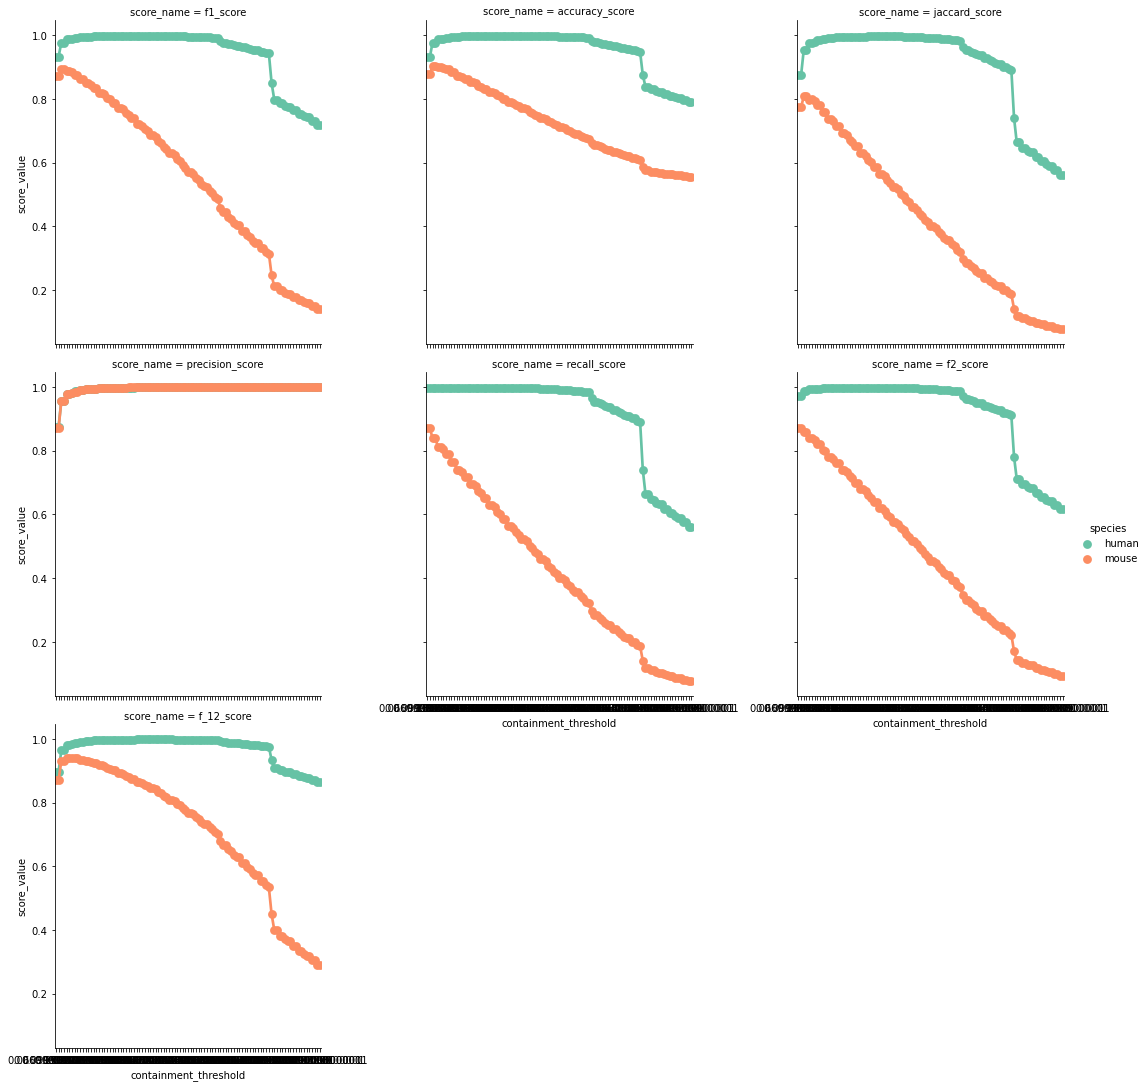

In [125]:
sns.catplot(
    x='containment_threshold', 
    y='score_value', 
    data=containment_threshold_metrics_protein8, 
    hue='species', 
    col='score_name', 
    col_wrap=3,
    palette='Set2',
    kind='point',
)

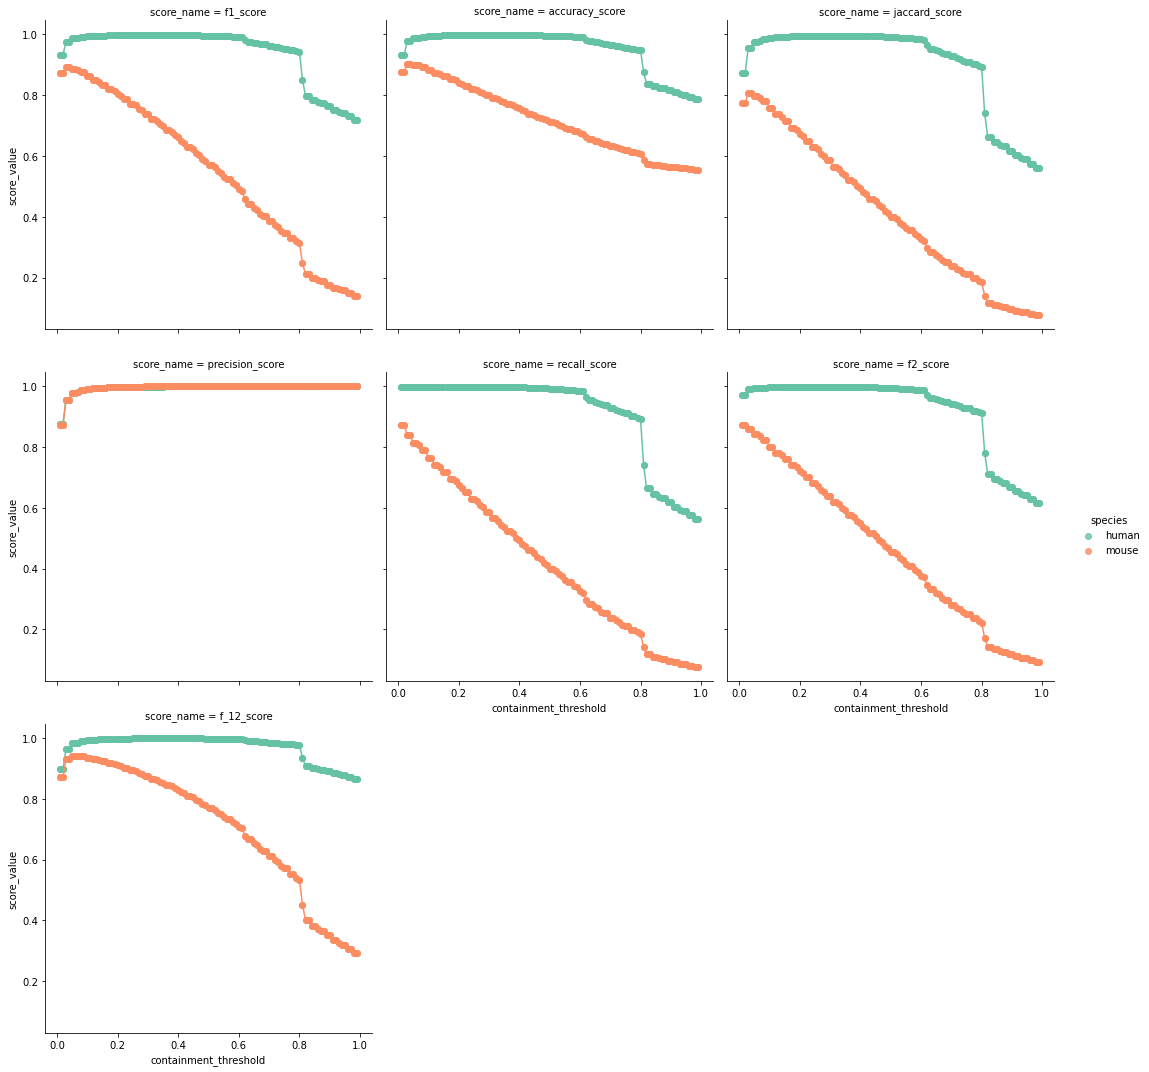

In [129]:
g = sns.lmplot(
    x='containment_threshold', 
    y='score_value', 
    data=containment_threshold_metrics_protein8, 
    hue='species', 
    col='score_name', 
    col_wrap=3,
    palette='Set2',
    fit_reg=False,
#     kind='point',
)
g.map(plt.plot, 'containment_threshold', 'score_value')

In [126]:
rows = containment_threshold_metrics_protein8.groupby(['species', 'score_name']).apply(lambda x: x['score_value'].idxmax())
containment_threshold_metrics_protein8.loc[rows]

,species,alphabet,ksize,score_value,score_name,containment_threshold
23574,human,protein,8,0.998164,accuracy_score,0.32
23466,human,protein,8,0.998092,f1_score,0.32
18714,human,protein,8,0.997771,f2_score,0.25
29406,human,protein,8,0.998632,f_12_score,0.39
23682,human,protein,8,0.996192,jaccard_score,0.32
73686,human,protein,8,0.999930,precision_score,0.98
462,human,protein,8,0.998230,recall_score,0.01
2460,mouse,protein,8,0.903856,accuracy_score,0.04
2352,mouse,protein,8,0.893674,f1_score,0.04
624,mouse,protein,8,0.872285,f2_score,0.01


## Protein, k=8, only $F_{1/2}$ and precision recall

In [154]:
score_names = ['precision_score', 'recall_score', 'f1_score', 'f_12_score',]
containment_threshold_metrics_protein8_f12_precision_recall = containment_threshold_metrics_protein8.query('score_name in @score_names')
containment_threshold_metrics_protein8_f12_precision_recall

,species,alphabet,ksize,score_value,score_name,containment_threshold
30,human,protein,8,0.932976,f1_score,0.01
84,mouse,protein,8,0.872542,f1_score,0.01
354,human,protein,8,0.875729,precision_score,0.01
408,mouse,protein,8,0.872972,precision_score,0.01
462,human,protein,8,0.998230,recall_score,0.01
...,...,...,...,...,...,...
74496,mouse,protein,8,1.000000,precision_score,0.99
74550,human,protein,8,0.561704,recall_score,0.99
74604,mouse,protein,8,0.075996,recall_score,0.99
74766,human,protein,8,0.864966,f_12_score,0.99


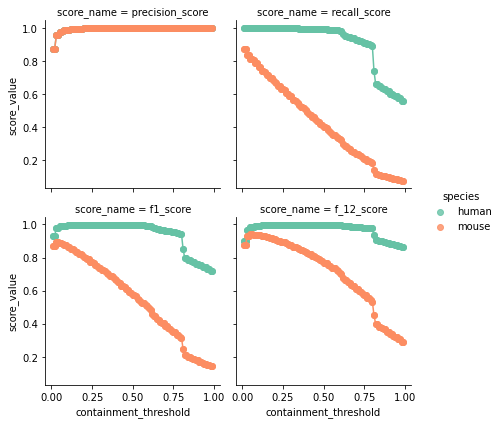

In [155]:
g = sns.lmplot(
    x='containment_threshold', 
    y='score_value', 
    data=containment_threshold_metrics_protein8_f12_precision_recall, 
    hue='species', 
    col='score_name', 
    col_wrap=2,
    palette='Set2',
    fit_reg=False,
    col_order=score_names,
    height=3,
#     scatter_kws=dict(markersize=5),
#     kind='point',
)
g.map(plt.plot, 'containment_threshold', 'score_value', linestyle='-')

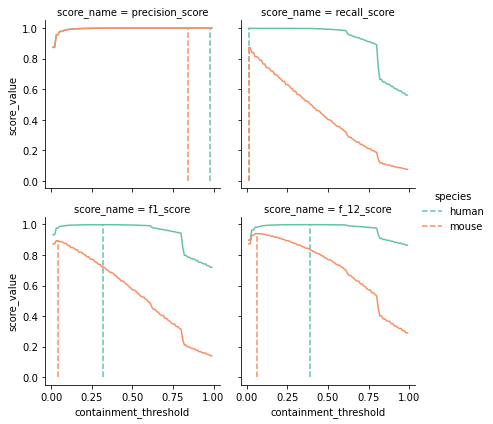

In [164]:
g = sns.FacetGrid(
#     x='containment_threshold', 
#     y='score_value', 
    data=containment_threshold_metrics_protein8_f12_precision_recall, 
    hue='species', 
    col='score_name', 
    col_wrap=2,
    palette='Set2',
    col_order=score_names,
    height=3,
)
g.map(plt.plot, 'containment_threshold', 'score_value', linestyle='-')
g.map(plot_argmax, 'containment_threshold', 'score_value')

g.add_legend()

### Plot only precision and recall

In [161]:
precision_recall = 'precision_score', 'recall_score'
containment_threshold_metrics_protein8_precision_recall = containment_threshold_metrics_protein8_f12_precision_recall.query('score_name in @precision_recall')
containment_threshold_metrics_protein8_precision_recall.shape

(396, 6)

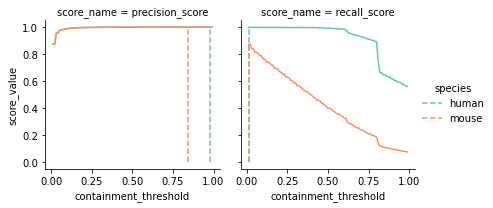

In [163]:
def plot_argmax(x, y, *args, **kwargs):
    idxmax = y.idxmax()
    plt.vlines(x[idxmax], 0, y.max(), linestyle='--', *args, **kwargs)
#     print('x:', x)
#     print('y:', y)
#     print('args:', args)
#     print('kwargs:', kwargs)
    pass

g = sns.FacetGrid(
#     x='containment_threshold', 
#     y='score_value', 
    data=containment_threshold_metrics_protein8_precision_recall, 
    hue='species', 
    col='score_name', 
    col_wrap=2,
    palette='Set2',
    col_order=precision_recall,
    height=3,
)
g.map(plt.plot, 'containment_threshold', 'score_value', linestyle='-')
g.add_legend()